In [160]:
import plotly.express as px
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(11.7*1.3, 8.27*1.3)})
sns.set_theme(style="whitegrid", palette="deep") #pastel
sns.set_context("paper", font_scale=1.5)

import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"

from fancyimpute import KNN

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sys import getsizeof
import missingno as msn

In [161]:
df = pd.read_csv('./data/titanic/train.csv')
df_test = pd.read_csv('./data/titanic/test.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Анализ признаков

### Посмотрим на пропущеные значения

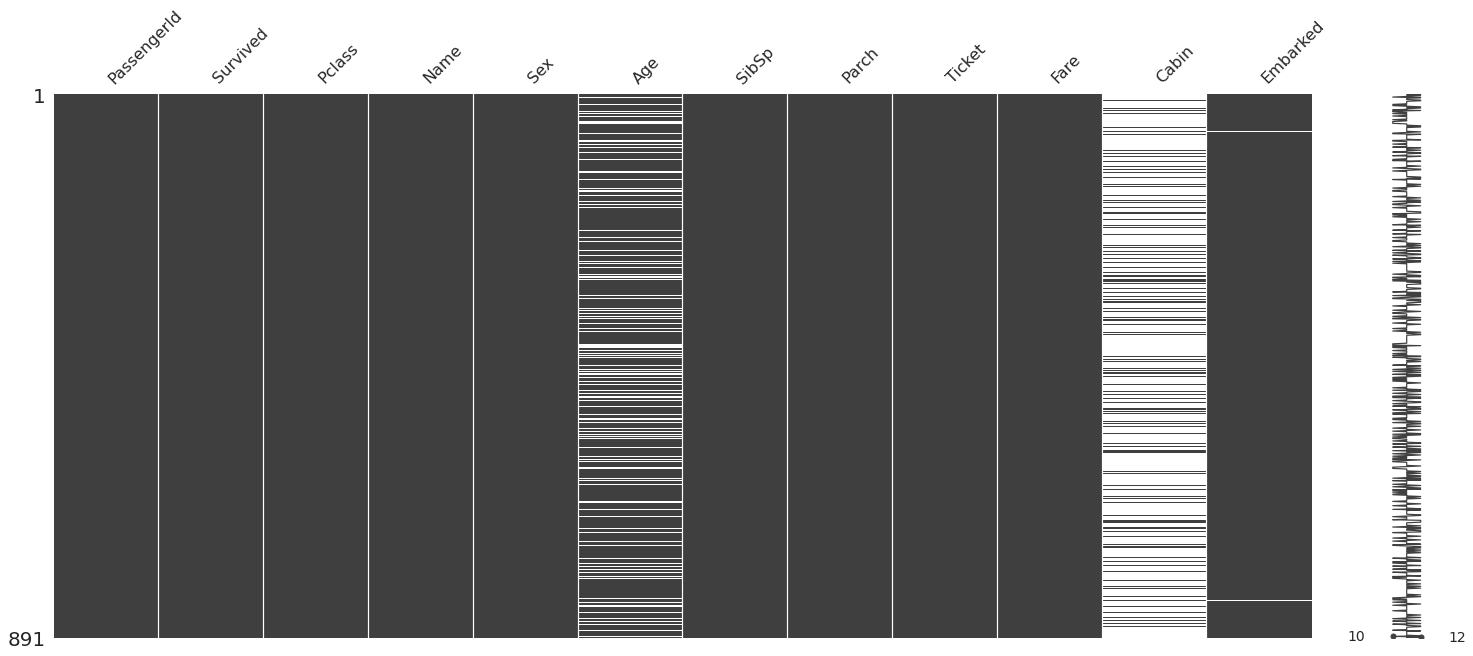

In [162]:
msn.matrix(df);

### Посмотрим на дубликаты в каждом признаке

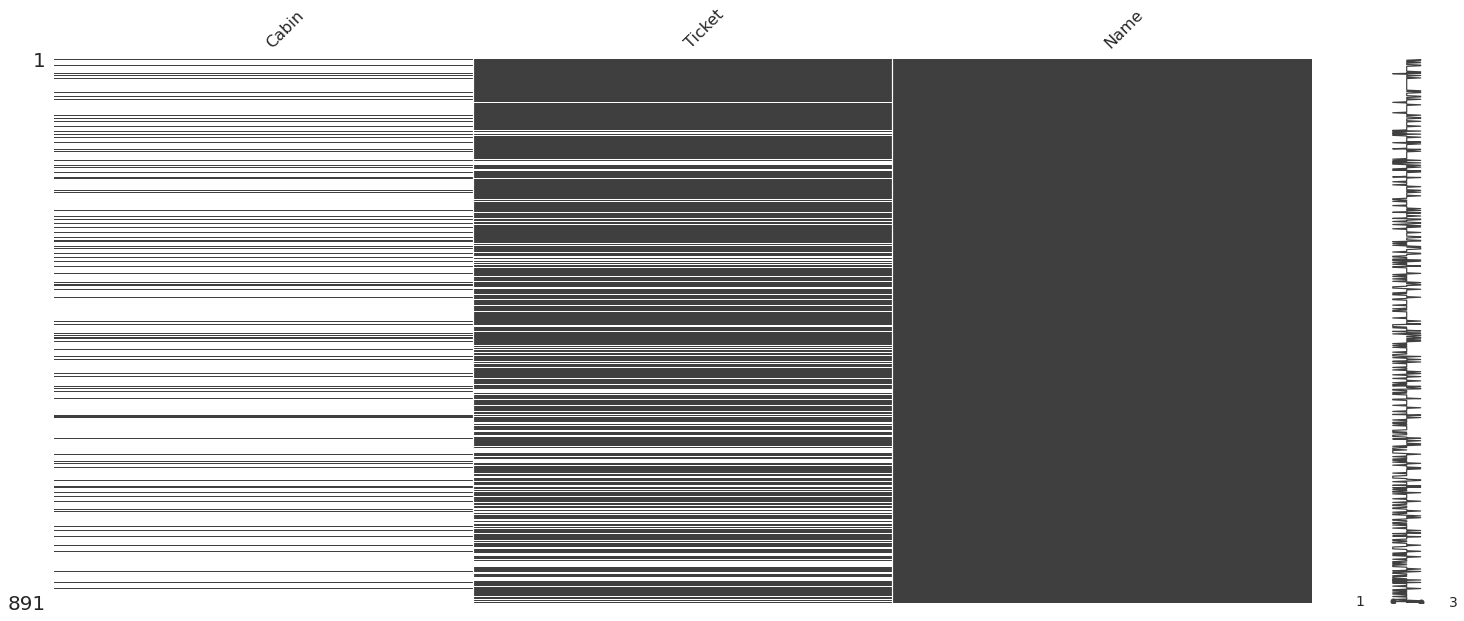

In [163]:
df_duplicateds = pd.DataFrame([(~df[col].duplicated()).astype(int).replace(0,np.nan) for col in ['Cabin', 'Ticket', 'Name']]).T
msn.matrix(df_duplicateds);

__________
### Какой процент выживыших для каждого класса?

In [164]:
df.groupby(['Pclass']).agg({'Survived':lambda x: f"{round(100*sum(x == 1)/ len(x), 2)}%"})

,Survived
Pclass,
1,62.96%
2,47.28%
3,24.24%


________
### Выжил или нет в зависимости от пола и возраста

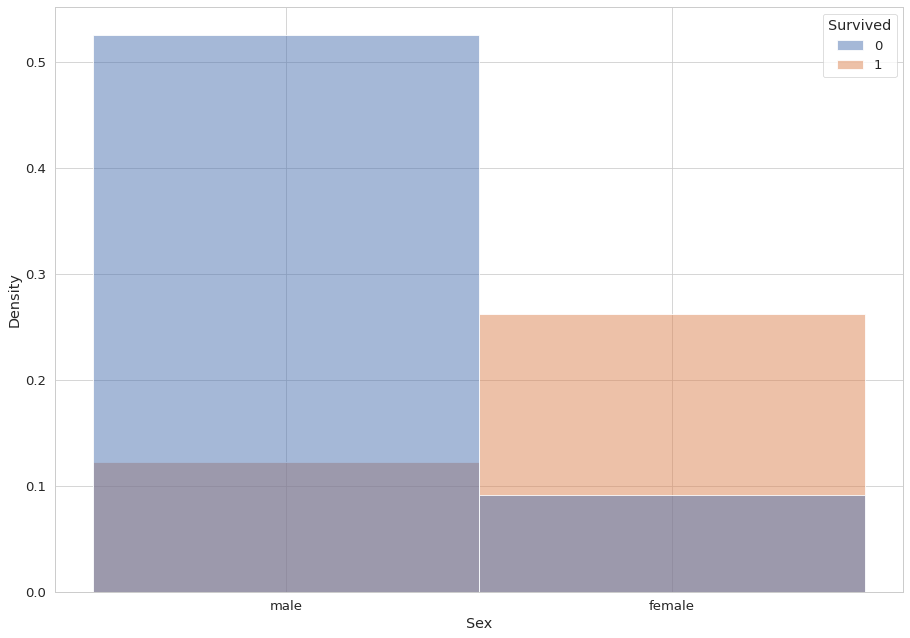

In [165]:
sns.histplot(df, x='Sex',hue='Survived', stat="density" );

#### видно, что женщины предпочтительнее выживают

________
### Как зависят количество родственников от выживаеомсти

In [169]:
df.groupby(['SibSp']).agg({'Survived':lambda x: f"{round(100*sum(x == 1)/ len(x), 2)}%"})

,Survived
SibSp,
0,34.54%
1,53.59%
2,46.43%
3,25.0%
4,16.67%
5,0.0%
8,0.0%


### Зависимость возраста, цены от выживыаемости в классах

In [180]:
df.groupby(['Pclass', 'Survived']).agg({'Age':['mean', 'median'], 'Fare':['mean', 'median']}).round(2)

Age          Fare       
                  mean median   mean median
Pclass Survived                            
1      0         43.70  45.25  64.68  44.75
       1         35.37  35.00  95.61  77.96
2      0         33.54  30.50  19.41  13.00
       1         25.90  28.00  22.06  21.00
3      0         26.56  25.00  13.67   8.05
       1         20.65  22.00  13.69   8.52

#### Можно сделать вывод, что лучше выживают более богатые, а также более молодые

,Survived
Embarked,
C,55.36%
Q,38.96%
S,33.7%


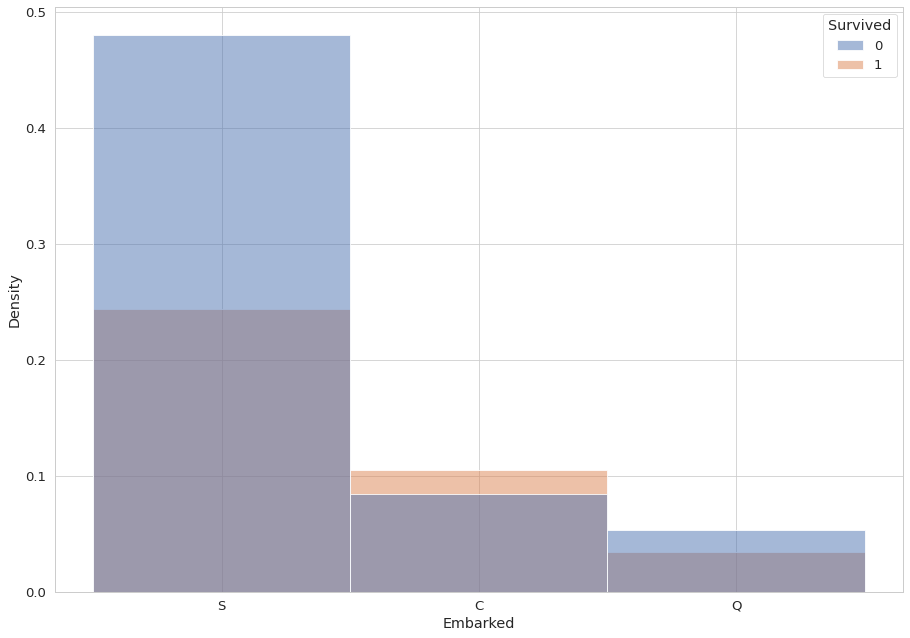

In [182]:
sns.histplot(df, x='Embarked',hue='Survived', stat="density" )
df.groupby(['Embarked']).agg({'Survived':lambda x: f"{round(100*sum(x == 1)/ len(x), 2)}%"})

#### люди, севшие в C выживут с вероятностью 55%

In [196]:
df.groupby(['Pclass', 'Embarked']).agg({'PassengerId':'count'})

PassengerId
Pclass Embarked             
1      C                  85
       Q                   2
       S                 127
2      C                  17
       Q                   3
       S                 164
3      C                  66
       Q                  72
       S                 353

# Обработка признаков

In [151]:
def claster_fillna(df, name_feature):
    #scaler = preprocessing.StandardScaler()
    index_feature = df.columns.tolist().index(name_feature)    
    #standardized_feature = scaler.fit_transform(df)

    impute_feature = KNN(k=2, verbose=0).fit_transform(df)[:, index_feature]
    return impute_feature


cols_cat =['Pclass', 'Sex', 'SibSp', 'Embarked', 'Ticket_duplicate', 'Ticket','Cabin', 'Cabin_count_psng']#Cabin_distance
cols_txt = ['Name']

# 22.86 Растояние от палубы, на которой находились спасательные шлюпки до нижнего жилого этажа
# 7 - количество жилых этажей
l = 22.86/7
distance_to_deck = {'A':l , 'B':2*l , 'C':3*l , 'D':4*l , 'F':5*l , 'E':6*l , 'G':7*l }

def clear_df(df):
    # создание признака, показывающий расстояние до верхней палубы
    df['Cabin_distance'] = df['Cabin'].apply(lambda x: distance_to_deck.get(str(x)[0], np.nan))
    # признак - состоит ли билет только из цифр
    df['Ticket_onlynum'] = df['Ticket'].apply(lambda x: int(x.isdigit()))
    # дубликатный ли билет (0 - нет, 1-да)
    df['Ticket_duplicate'] = df['Ticket'].duplicated().astype(int)
    # количество пассажиров в кабине
    df['Cabin_count_psng'] = df['Cabin'].astype(str).map(lambda x: len(x.split(' ')))
    # 
    df['Embarked'] = df['Embarked'].apply(lambda x: {'S':0, 'C':1, 'Q':2}.get(x, -1))
    df['Sex'] = df['Sex'].apply(lambda x: {'male':0, 'female':1}.get(x, -1))
    
    df['Cabin_distance'] = claster_fillna(df.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked', 'PassengerId']), 'Cabin_distance')
    
    df = df.drop(columns=['PassengerId'])
    df[['Fare', 'Parch']] = df[['Fare', 'Parch']].fillna(-1)
    df[['Fare', 'Parch']] = df[['Fare', 'Parch']].astype(int)
    
    # Названия с очень низким количеством ячеек будут объединены до уровня "редкие"
    rare_titles = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
    df['Name'].replace(rare_titles, "Rare title", inplace=True)
    # "Mlle","Ms", "Mme" переводим в шкалу "Miss", "Mrs"
    df['Name'].replace(["Mlle","Ms", "Mme"], ["Miss", "Miss", "Mrs"], inplace=True)
    
    #df['Words_in_name'] = df['Name'].str.findall('[A-Za-z]+').apply(len)
    # берем только имя
    #df['Name'] = df['Name'].apply(lambda x: x.split(',')[0].strip())

    
    df[cols_cat] = df[cols_cat].fillna('')
    df[cols_txt] = df[cols_txt].fillna('')
    df[cols_cat] = df[cols_cat].astype(str)
    df[cols_txt] = df[cols_txt].astype(str)
    return df

In [152]:
df_target = df.pop('Survived')
df = clear_df(df)
df_test = clear_df(df_test)

## Индексы категориальных и текстовых фичей

In [153]:
cat_ind = [i for i, col in enumerate(df.columns) if col in cols_cat]
text_ind = [i for i, col in enumerate(df.columns) if col in cols_txt]

## Разделение на тесотвую и валидационную подвыборки

In [154]:
X_train, X_test, y_train, y_test = train_test_split(df.values,
                                                    df_target.values,
                                                    train_size=0.8,
                                                    random_state=42)

# Обучение модели

In [155]:
model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.0005,
                           l2_leaf_reg=0.1,
                           random_seed=42,
                           eval_metric='Accuracy',
                           use_best_model=True,
                           #od_type='Iter',
                           #od_wait=200,
                           bagging_temperature=0.5,
                           verbose=False)

model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_ind,
    text_features=text_ind,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Точность на валидационной подвыборке

In [156]:
accuracy_score( y_test, model.predict(X_test) )

0.8379888268156425

In [157]:
sorted(list(zip(full_model.feature_importances_, df.columns)), key=lambda x:x[0])

[(0.33378176608483306, 'Ticket_onlynum'),
 (0.4471405377710139, 'Ticket_duplicate'),
 (0.6991151322424781, 'Parch'),
 (2.0759861858986444, 'Cabin_distance'),
 (2.3408482337102203, 'Cabin_count_psng'),
 (2.6469387845298034, 'Age'),
 (2.827243269140473, 'Fare'),
 (4.482518989440543, 'Embarked'),
 (4.976055240634605, 'SibSp'),
 (6.961213028749372, 'Cabin'),
 (10.160486516365953, 'Pclass'),
 (13.270773559466509, 'Ticket'),
 (15.759100578280112, 'Sex'),
 (33.018798177685625, 'Name')]

In [79]:
model.get_params()

{'bagging_temperature': 0.5,
 'eval_metric': 'Accuracy',
 'verbose': False,
 'use_best_model': True,
 'random_seed': 42,
 'l2_leaf_reg': 0.1,
 'learning_rate': 0.0005,
 'iterations': 10000}

# Обучение на полных данных

In [80]:
full_model = CatBoostClassifier(**model.get_params())

full_model.fit(
    df.values,
    df_target.values,
    eval_set=(X_test, y_test),
    cat_features=cat_ind,
    text_features=text_ind,
)

##  Сохранение предсказаний для kaggle

In [81]:
predicts = full_model.predict(df_test.values)
df_sub = pd.read_csv('./data/titanic/gender_submission.csv')
df_sub['Survived'] = predicts
df_sub.to_csv('gender_submission.csv', index=False)